# Paraschiv Gait Sequence Detection

This example can be referenced by citing the package.

The example illustrates how the Paraschiv gait sequence detection algorithm is used to detect gait sequences using body acceleration recorded with a triaxial accelerometer worn or fixed on the lower back. The gait sequence detection algorithm is implemented using [`ngmt.modules.gsd._paraschiv`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/gsd/_paraschiv.py). This algorithm is based on the research of Paraschiv-Ionescu et al [1-2].

The algorithm detects gait sequences based on identified steps. It starts by loading the accelerometer data, which includes three columns corresponding to the acceleration signals across the x, y, and z axes, along with the sampling frequency of the data. To simplify the analysis, the norm of acceleration across the x, y, and z axes is computed. Next, the signal is resampled at a 40 Hz sampling frequency using interpolation. Smoothing is then applied through a Savitzky-Golay filter and a Finite Impulse Response (FIR) low-pass filter to remove noise and drifts from the signal. The continuous wavelet transform is applied to capture gait-related features, followed by additional smoothing using successive Gaussian-weighted filters. The processed data is then analyzed to detect gait sequences.

The algorithm continues by identifying the envelope of the processed acceleration signal. Active periods of the signal are identified using the Hilbert envelope. The statistical distribution of the amplitude of the peaks in these active periods is used to derive an adaptive threshold. In case the Hilbert envelope algorithm fails to detect active periods, a fixed threshold value (0.15 g) is used for peak detection in the signal. Mid-swing peaks are detected based on this threshold. Pulse trains in the local maximum and minimum of the peaks are identified, with those having fewer than four steps filtered out. The intersection of pulse trains from local maximum and minimum peaks is detected as walking periods. These periods are then organized and grouped to update the start and end times of detected walking bouts.

Next, the algorithm takes the last steps to detect walking bouts in the signal. For this purpose, walking bouts with five or more steps are detected, and their start and end times are added to the list. Walking labels are generated as an array of zeros, and the intervals corresponding to the walking bouts are labeled as 1. Groups of consecutive zeros in the walking labels are identified, and if breaks between walking bouts are less than three seconds, they are merged. The output is then constructed as a DataFrame containing gait sequence information in BIDS format. If gait sequences are found, the output is printed; otherwise, a message indicating that no gait sequences are detected is displayed.

[1] Paraschiv-Ionescu et al. (2019). Locomotion and cadence detection using a single trunk-fixed accelerometer:
    validity for children with cerebral palsy in daily life-like conditions. Journal of NeuroEngineering and Rehabilitation, 16(1), 24.
    https://doi.org/10.1186/s12984-019-0494-z

[2] Paraschiv-Ionescu et al. (2020). Real-world speed estimation using single trunk
IMU: methodological challenges for impaired gait patterns.
    Annual International Conference of the IEEE Engineering in Medicine and Biology Society. IEEE Engineering in Medicine and Biology Society.
    https://doi.org/10.1109/EMBC44109.2020.9176281

## Import libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset, and gait sequence detection module are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the 'ngmt' library and its dependencies if you haven't already.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ngmt.datasets import mobilised
from ngmt.modules.gsd import ParaschivIonescuGaitSequenceDetection
from ngmt.config import cfg_colors

## Data Preparation

To implement the gait sequence detection algorithm, we load example data from a congestive heart failure (CHF) cohort, which is publicly available on the Zenodo repository [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7547125.svg)](https://doi.org/10.5281/zenodo.7547125). 

The participant was assessed for 2.5 hours in the real-world while doing different daily life activities and also was asked to perform specific tasks such as outdoor walking, walking up and down a slope and stairs and moving from one room to another [`3`].

Since we will use norm of the accleration signal to detect gait sequences, we don't need to take care of orientation of the signal.

Refertences

.. [`3`] Mazzà, Claudia, et al. "Technical validation of real-world monitoring of gait: a multicentric observational study." BMJ open 11.12 (2021): e050785. http://dx.doi.org/10.1136/bmjopen-2021-050785


In [2]:
# The 'file_path' variable holds the absolute path to the data file
file_path = (
    r"C:\Users\Project\Desktop\Gait_Sequence\Mobilise-D dataset_1-18-2023\CHF\data.mat"
)

# In this example, we use "SU" as tracking_system and "LowerBack" as tracked points.
tracking_sys = "SU"
tracked_points = {tracking_sys: ["LowerBack"]}

# The 'mobilised.load_recording' function is used to load the data from the specified file_path
recording = mobilised.load_recording(
    file_name=file_path, tracking_systems=[tracking_sys], tracked_points=tracked_points
)

# Load lower back acceleration data
acceleration_data = recording.data[tracking_sys][
    ["LowerBack_ACCEL_x", "LowerBack_ACCEL_y", "LowerBack_ACCEL_z"]
]

# Get the corresponding sampling frequency
sampling_frequency = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "LowerBack_ACCEL_x"
]["sampling_frequency"].values[0]

## Visualisation of the Data
The raw acceleration data including components of x, y and z axis is represented.

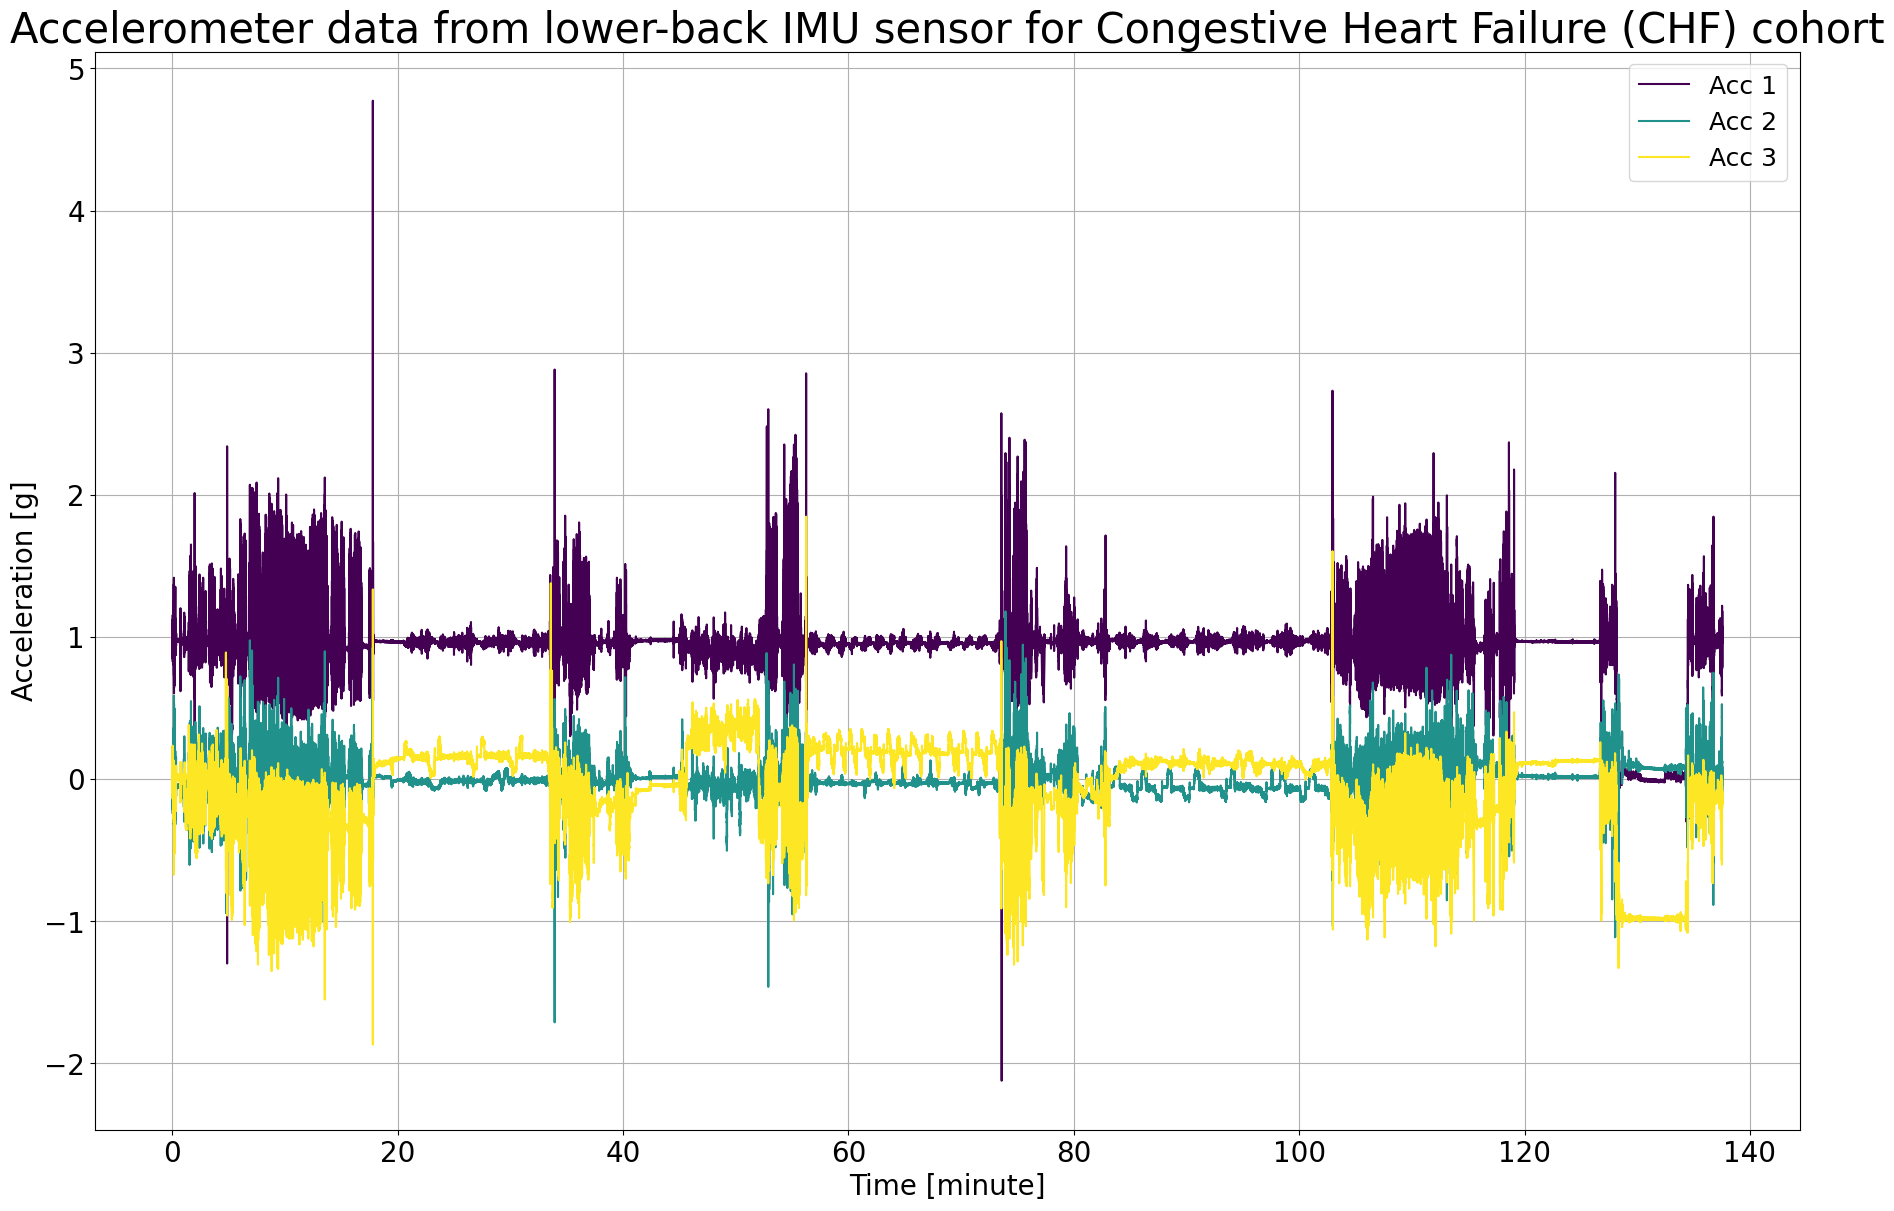

In [3]:
# Calculate the time values in minutes
# The 'time_in_minute' array represents time values in minutes, computed based on the length of 'acceleration_data' and 'sampling_frequency'.
time_in_minute = np.arange(len(acceleration_data)) / (60 * sampling_frequency)

# Create a figure with a specified size
plt.figure(figsize=(22, 14))

# Get colors for raw
colors = cfg_colors["raw"]

# A loop is used to plot data for each accelerometer axis, applying different colors from the color map.
for i in range(3):
    plt.plot(
        time_in_minute,
        acceleration_data[f"LowerBack_ACCEL_{chr(120 + i)}"],
        color=colors[i],
        label=f"Acc {i + 1}",
    )

# Add labels and legends
plt.xlabel("Time [minute]", fontsize=20)
plt.ylabel("Acceleration [g]", fontsize=20)
plt.legend(fontsize=18)

# Add a title with a specified font size
plt.title(
    "Accelerometer data from lower-back IMU sensor for Congestive Heart Failure (CHF) cohort",
    fontsize=30,
)

# Customize tick font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()

Let's zoom in on specific time periods in the data, particularly the first 10 seconds, where clear blinks are evident.

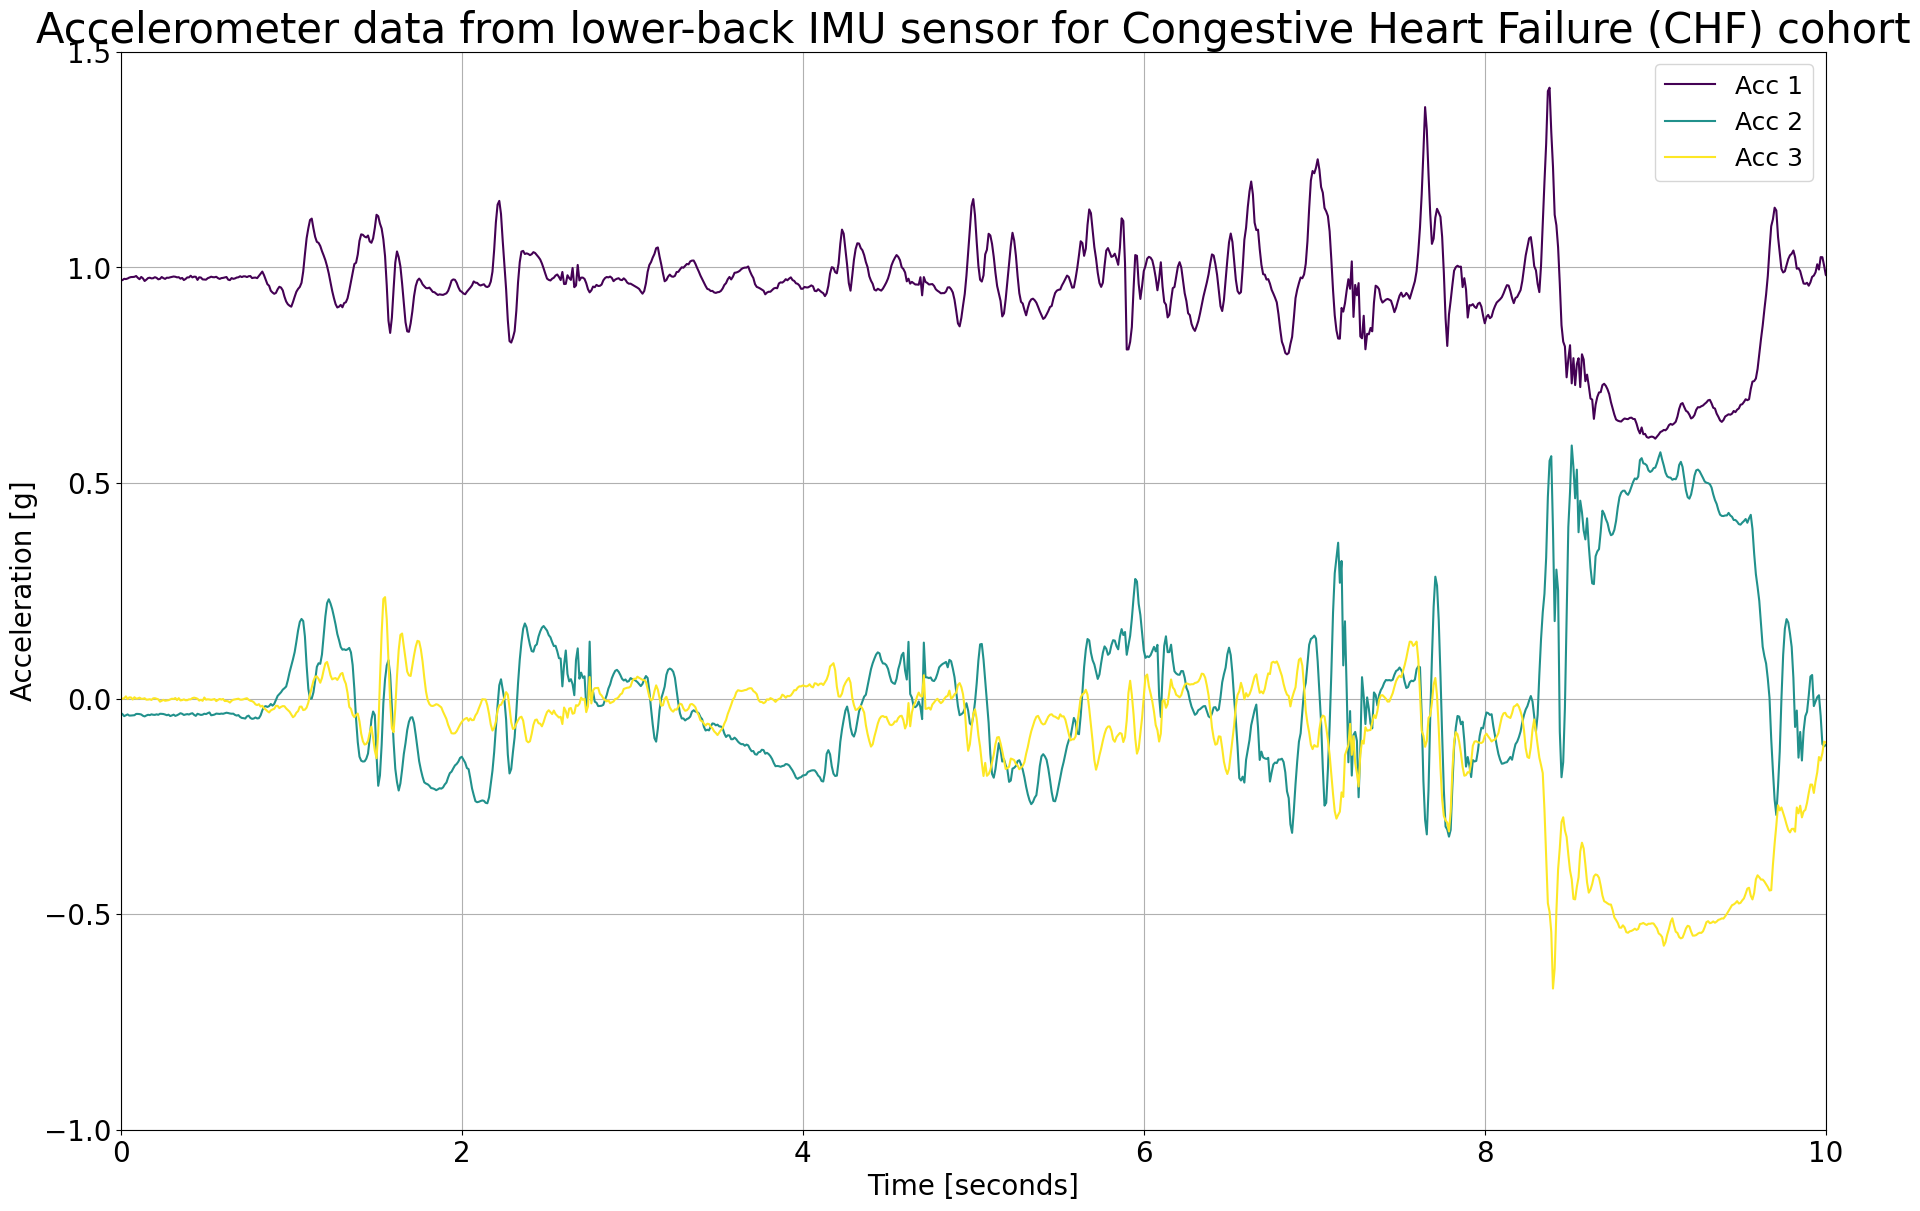

In [4]:
# Calculate the time values based on the length of the data
num_samples = len(acceleration_data)
time_seconds = np.arange(num_samples) / sampling_frequency

# Create a figure with the specified size
plt.figure(figsize=(22, 14))

# Plot acceleration data for each axis with time on the x-axis
for i in range(3):
    plt.plot(
        time_seconds,
        acceleration_data[f"LowerBack_ACCEL_{chr(120 + i)}"],
        color=colors[i],
        label=f"Acc {i + 1}",
    )

# Add labels and legends
plt.xlabel("Time [seconds]", fontsize=20)
plt.ylabel("Acceleration [g]", fontsize=20)
plt.legend(fontsize=18)

# Add a title
plt.title(
    "Accelerometer data from lower-back IMU sensor for Congestive Heart Failure (CHF) cohort",
    fontsize=30,
)

# Customize font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Set x-axis and y-axis limits for a specific duration (in seconds) and acceleration range
plt.xlim(0, 10)
plt.ylim(-1, 1.5)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()

## Applying the gait sequence detection algorithm
Now, we are running gait sequence detection algorithm (Paraschiv Ionescu) from [`NGMT.ngmt.modules.gsd._paraschiv.ParaschivIonescuGaitSequenceDetection`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/gsd/_paraschiv.py).  The inputs consist of accelerometer data (N, 3) for the x, y, and z axes, the initial sampling frequency of the data, and a plot option. Optionally, if the plot_results flag is set to True, a visualization plot is generated to display the preprocessed data and the detected gait sequences.

The onset is represented with the vertical green line and the grey area represents the duration of gait sequence detected by the algorithm.

86 gait sequence(s) detected.


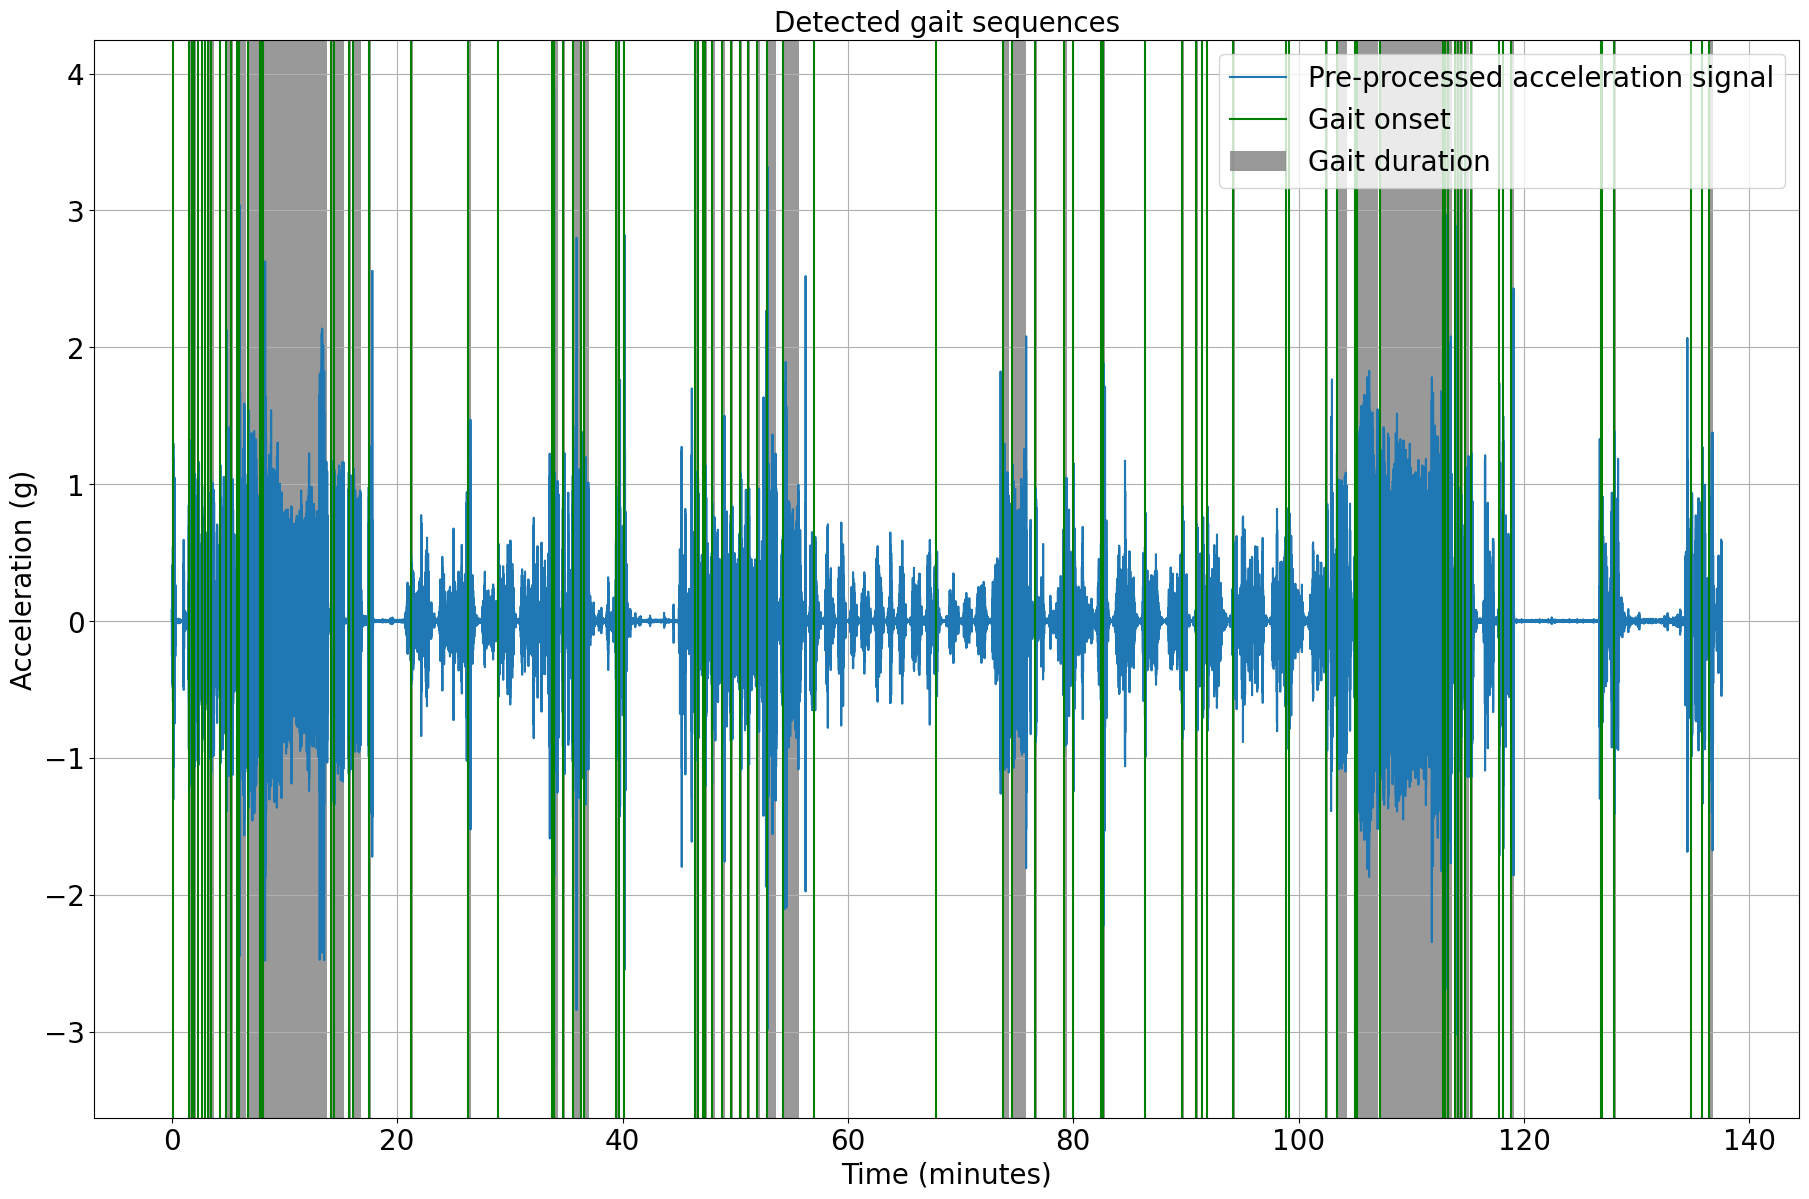

{'SU':        onset  duration     event_type tracking_systems tracked_points
0      4.500     5.250  gait sequence               SU      LowerBack
1     90.225    10.300  gait sequence               SU      LowerBack
2    106.075     5.600  gait sequence               SU      LowerBack
3    116.225    10.350  gait sequence               SU      LowerBack
4    141.275     5.850  gait sequence               SU      LowerBack
..       ...       ...            ...              ...            ...
81  7617.150     4.150  gait sequence               SU      LowerBack
82  7679.425    10.625  gait sequence               SU      LowerBack
83  8090.625     4.200  gait sequence               SU      LowerBack
84  8149.850     5.050  gait sequence               SU      LowerBack
85  8184.875    21.450  gait sequence               SU      LowerBack

[86 rows x 5 columns]}


In [5]:
# Create an instance of the ParaschivIonescuGaitSequenceDetection class
gsd = ParaschivIonescuGaitSequenceDetection(target_sampling_freq_Hz=40)

# Call the gait sequence detection using gsd.detect
gsd = gsd.detect(
    data=acceleration_data, sampling_freq_Hz=sampling_frequency, plot_results=True
)

# Gait sequences are stored in gait_sequences_ attribute of gsd
gait_sequences = gsd.gait_sequences_

# Add events to the recording as a dictionary including tracking system and events
gait_sequence_events = gait_sequences
recording.add_events(tracking_system = tracking_sys, new_events = gait_sequence_events)

# Show events and their corresponding information
print(recording.events)

Let's zoom in on specific time periods in the raw acceleration data, particularly the first detected gait sequence.

First gait sequence:
 onset                         4.5
duration                     5.25
event_type          gait sequence
tracking_systems               SU
tracked_points          LowerBack
Name: 0, dtype: object


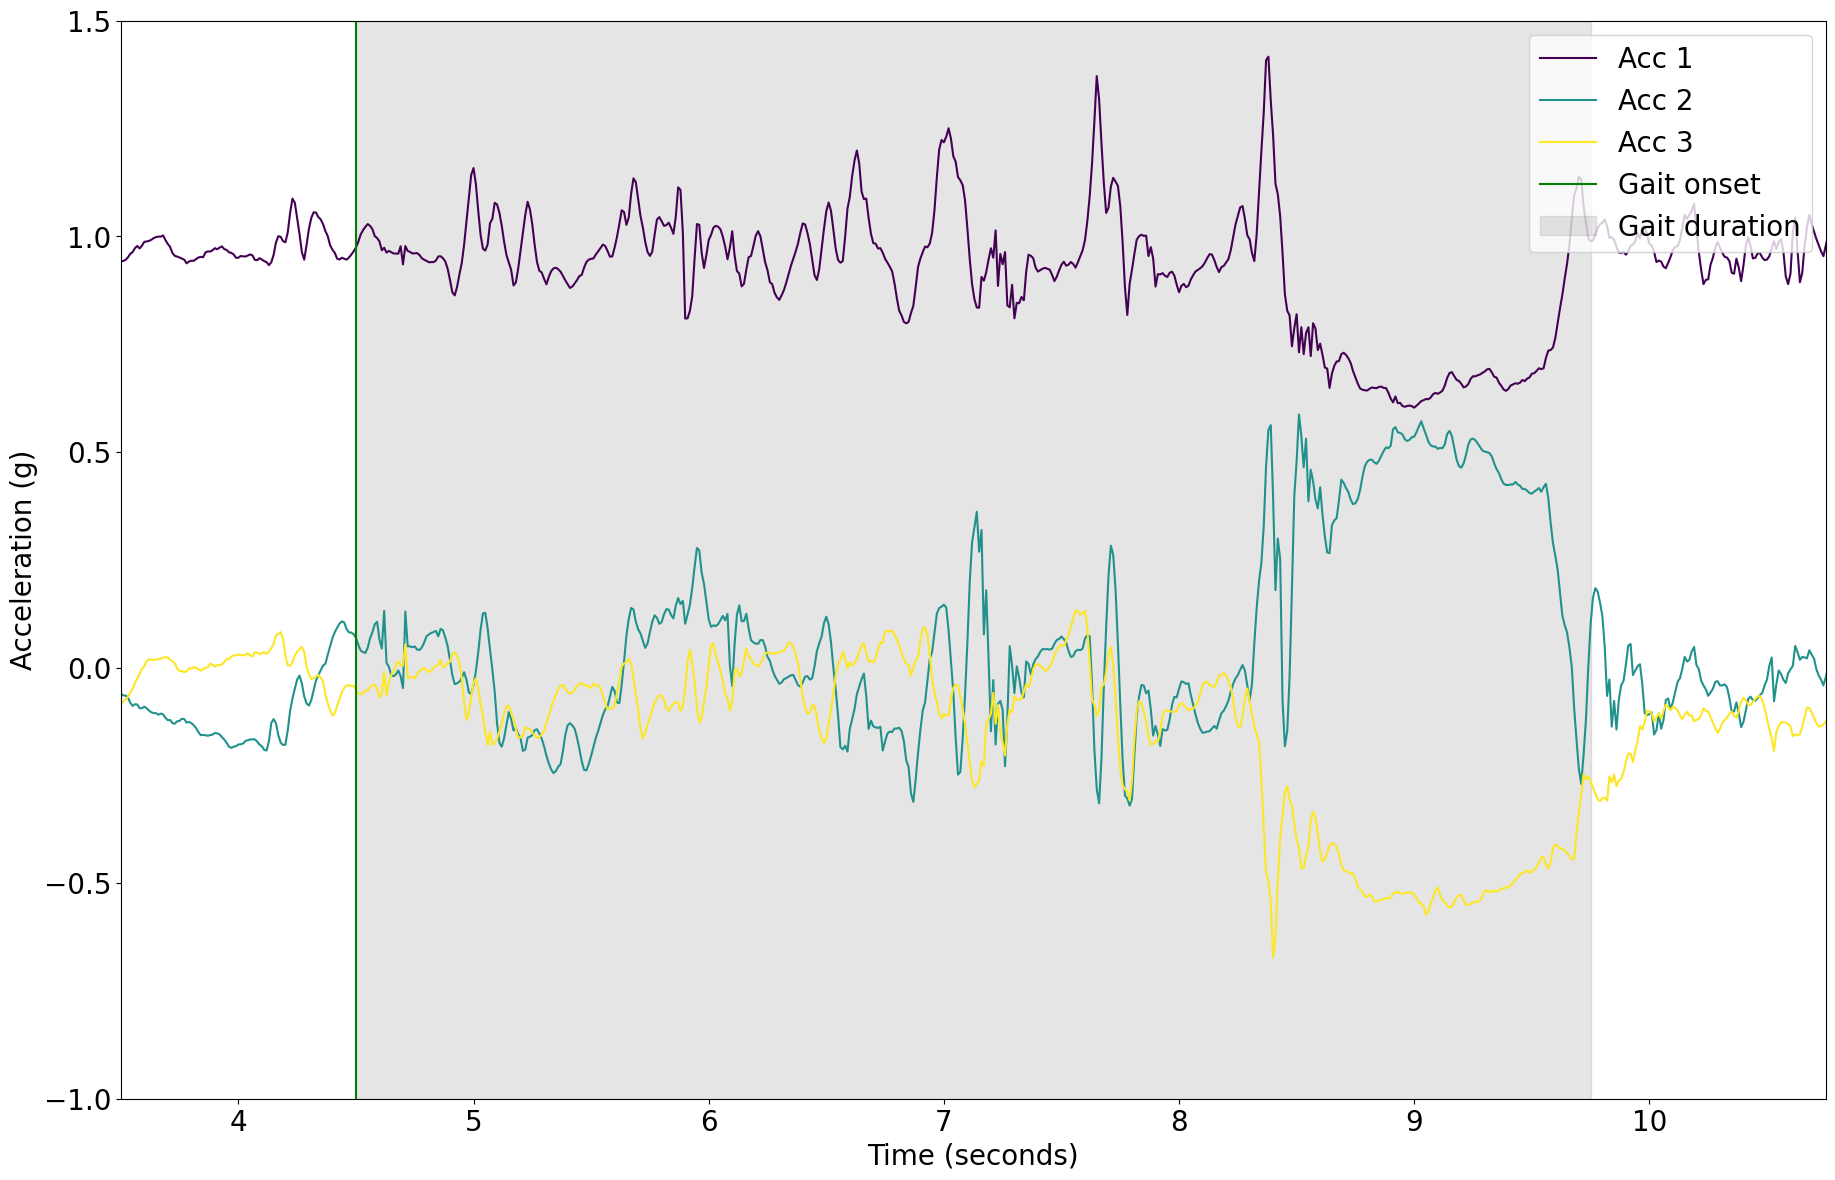

In [6]:
# Access the first detected gait sequence
first_gait_sequence = recording.events[tracking_sys].iloc[0]
print("First gait sequence:\n", first_gait_sequence)

# Plot the raw data from the lower back
fig, ax = plt.subplots(figsize=(22, 14))

# Plot the acceleration data
for i in range(3):
    ax.plot(
        time_seconds,
        acceleration_data[f"LowerBack_ACCEL_{chr(120 + i)}"],
        color=colors[i],
        label=f"Acc {i + 1}",
    )

# Plot the first element of gait sequences if they exist
plt.axvline(first_gait_sequence["onset"], color="g", label="Gait onset")
ax.axvspan(
    first_gait_sequence["onset"],
    first_gait_sequence["onset"] + first_gait_sequence["duration"],
    alpha=0.2,
    color="gray",
    label="Gait duration",
)

# Customize plot
start_limit = first_gait_sequence["onset"] - 1
end_limit = first_gait_sequence["onset"] + first_gait_sequence["duration"] + 1
ax.set_xlim(start_limit, end_limit)
ax.set_ylim(-1, 1.5)
ax.set_xlabel("Time (seconds)", fontsize=20)
ax.set_ylabel("Acceleration (g)", fontsize=20)
ax.legend(loc="upper right", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()